In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv('games.csv')
df.head()

df.keys()

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DiscountDLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [4]:
df.columns = ['Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'Discount', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies']


In [5]:
df['is_recommended'] = (df['Positive'] > df['Negative']).astype(int)
print(df['is_recommended'])

20200      0
655370     1
1732930    0
1355720    1
1139950    1
          ..
3600970    1
3543710    0
3265370    1
3423620    0
3183790    0
Name: is_recommended, Length: 111452, dtype: int64


In [6]:
selected_columns = [
    'Price', 'Required age', 'Achievements',
    'Average playtime forever', 'Average playtime two weeks',
    'Median playtime forever', 'Median playtime two weeks',
    'Windows', 'Mac', 'Linux',
    'Genres', 'Categories', 'Tags'
]

X = df[selected_columns].copy()
y = df['is_recommended']
print(y.value_counts(normalize=True))

print(X.isnull().sum())

X[['Genres', 'Categories', 'Tags']] = X[['Genres', 'Categories', 'Tags']].fillna('Unknown')
# print(X.isnull().sum())


is_recommended
1    0.556607
0    0.443393
Name: proportion, dtype: float64
Price                             0
Required age                      0
Achievements                      0
Average playtime forever          0
Average playtime two weeks        0
Median playtime forever           0
Median playtime two weeks         0
Windows                           0
Mac                               0
Linux                             0
Genres                         6440
Categories                     7566
Tags                          37423
dtype: int64


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd


for col in ['Genres', 'Categories', 'Tags']:
    X[col] = X[col].fillna('').apply(lambda x: x.split(',') if x else [])


mlb_genres = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb_genres.fit_transform(X['Genres']),
    columns=[f'Genre_{g}' for g in mlb_genres.classes_]
)


mlb_categories = MultiLabelBinarizer()
categories_encoded = pd.DataFrame(
    mlb_categories.fit_transform(X['Categories']),
    columns=[f'Category_{c}' for c in mlb_categories.classes_]
)


mlb_tags = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(
    mlb_tags.fit_transform(X['Tags']),
    columns=[f'Tag_{t}' for t in mlb_tags.classes_]
)


X.reset_index(drop=True, inplace=True)
genres_encoded.reset_index(drop=True, inplace=True)
categories_encoded.reset_index(drop=True, inplace=True)
tags_encoded.reset_index(drop=True, inplace=True)


X.drop(columns=['Genres', 'Categories', 'Tags'], inplace=True)


X = pd.concat([X, genres_encoded, categories_encoded, tags_encoded], axis=1)



               Price   Required age   Achievements  Average playtime forever  \
count  111452.000000  111452.000000  111452.000000             111452.000000   
mean        7.061568       0.254208      17.511144                 81.247290   
std        12.563246       2.035653     150.139008                999.935906   
min         0.000000       0.000000       0.000000                  0.000000   
25%         0.990000       0.000000       0.000000                  0.000000   
50%         3.990000       0.000000       0.000000                  0.000000   
75%         9.990000       0.000000      17.000000                  0.000000   
max       999.980000      21.000000    9821.000000             145727.000000   

       Average playtime two weeks  Median playtime forever  \
count               111452.000000            111452.000000   
mean                     9.174954                72.651330   
std                    168.201030              1321.333137   
min                      0.0000

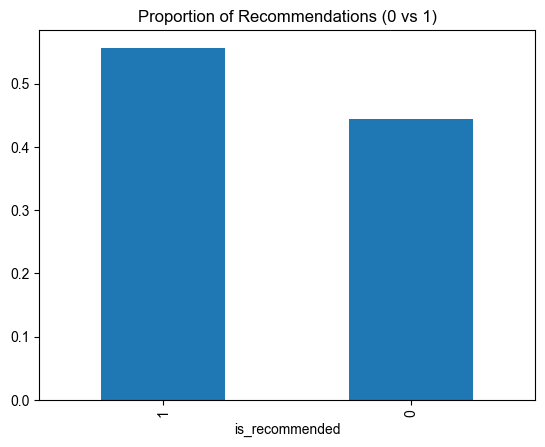

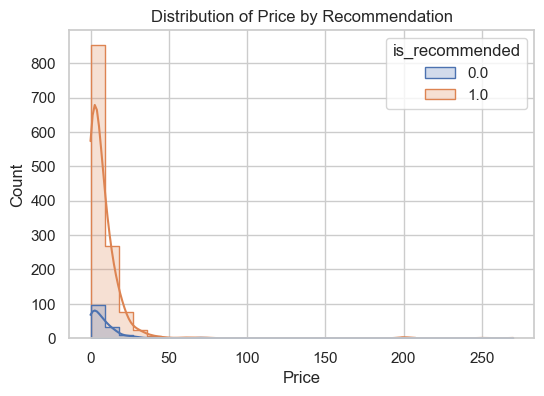

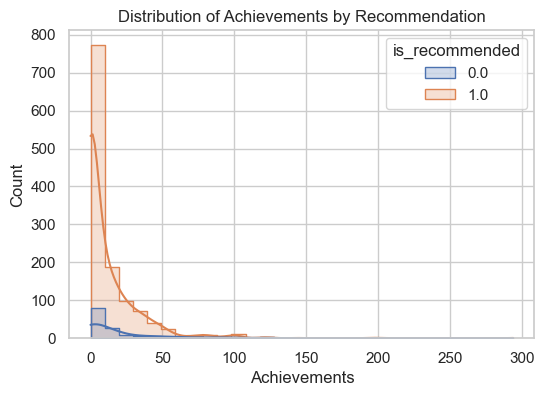

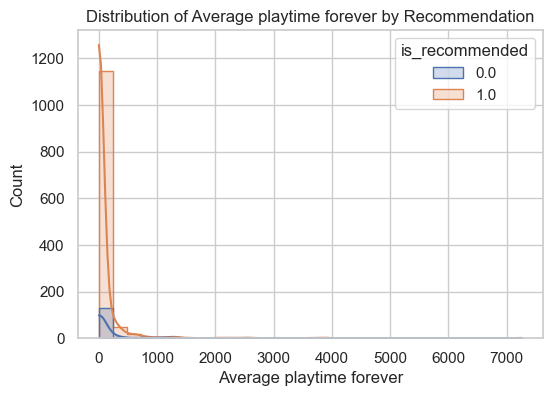

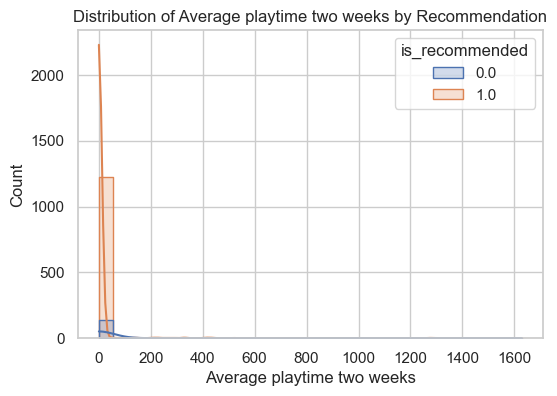

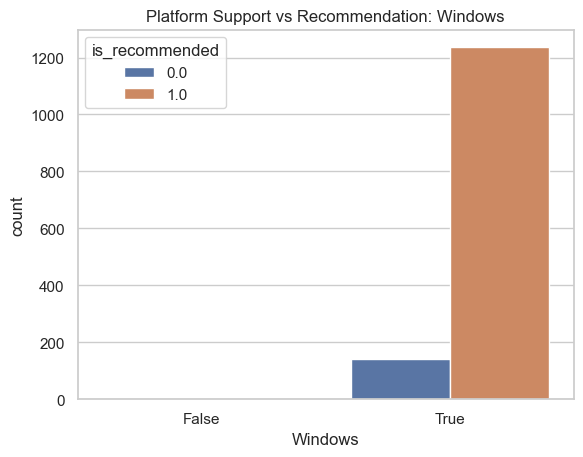

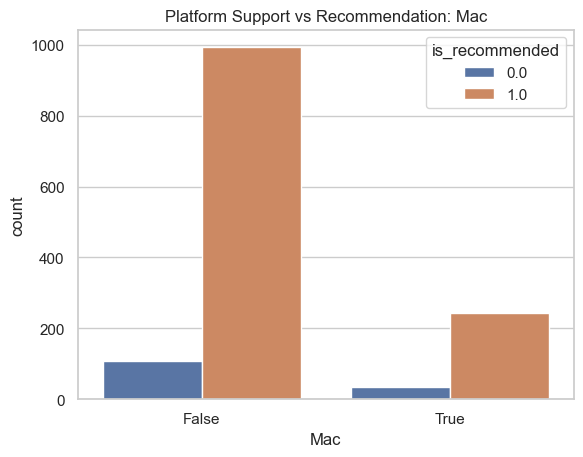

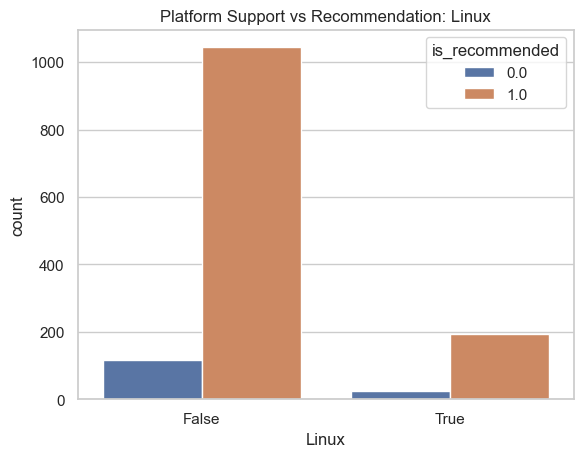

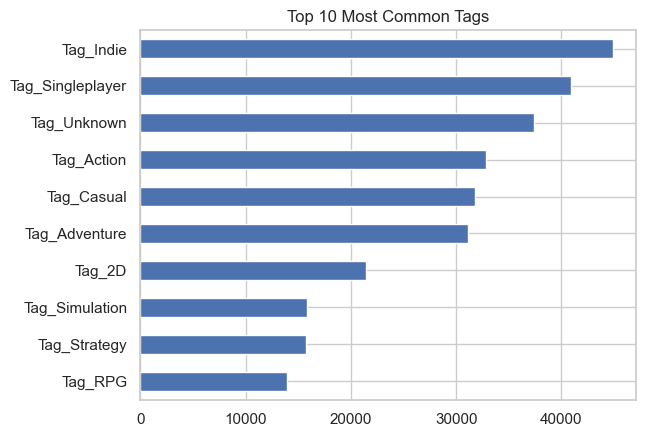

In [8]:
print(X.describe())

y.value_counts(normalize=True).plot(kind='bar', title='Proportion of Recommendations (0 vs 1)')

import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
num_cols = ['Price', 'Achievements', 'Average playtime forever', 'Average playtime two weeks']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=X, x=col, hue=y, kde=True, bins=30, element='step')
    plt.title(f'Distribution of {col} by Recommendation')
    plt.show()

platform_cols = ['Windows', 'Mac', 'Linux']
X_temp = X.copy()
X_temp['is_recommended'] = y

for col in platform_cols:
    sns.countplot(x=col, hue='is_recommended', data=X_temp)
    plt.title(f'Platform Support vs Recommendation: {col}')
    plt.show()

top_tags = X.filter(like='Tag_').sum().sort_values(ascending=False).head(10)
top_tags.plot(kind='barh', title='Top 10 Most Common Tags')
plt.gca().invert_yaxis()
plt.show()


In [9]:
from sklearn.preprocessing import StandardScaler
#option normalization step
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    if y_proba is not None:
        print("AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))



 Logistic Regression
Accuracy: 0.8941725360010767
AUC: 0.9357528918431152
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      9884
           1       0.84      0.99      0.91     12407

    accuracy                           0.89     22291
   macro avg       0.92      0.88      0.89     22291
weighted avg       0.91      0.89      0.89     22291


 Random Forest
Accuracy: 0.8954286483334081
AUC: 0.9399660140812274
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      9884
           1       0.85      0.98      0.91     12407

    accuracy                           0.90     22291
   macro avg       0.91      0.88      0.89     22291
weighted avg       0.91      0.90      0.89     22291



In [12]:
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
y_proba = mlp_model.predict_proba(X_test)[:, 1]

print("\n MLP")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))



 MLP
Accuracy: 0.8497151316674891
AUC: 0.9129771146867294
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      9884
           1       0.86      0.87      0.87     12407

    accuracy                           0.85     22291
   macro avg       0.85      0.85      0.85     22291
weighted avg       0.85      0.85      0.85     22291



In [13]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))



 XGBoost
Accuracy: 0.8957875375712171
AUC: 0.9414891185401174
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      9884
           1       0.85      0.99      0.91     12407

    accuracy                           0.90     22291
   macro avg       0.92      0.88      0.89     22291
weighted avg       0.91      0.90      0.89     22291



In [14]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

print("\n LightGBM")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 49628, number of negative: 39533
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2997
[LightGBM] [Info] Number of data points in the train set: 89161, number of used features: 513
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556611 -> initscore=0.227419
[LightGBM] [Info] Start training from score 0.227419

 LightGBM
Accuracy: 0.8961015656543
AUC: 0.9421046165013633
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      9884
           1       0.84      1.00      0.91     12407

    accuracy                           0.90     22291
   macro avg       0.92      0.88      0.89     22291
weighted avg       0.91      0.90      0.89     22291

